This notebook is used to preprocess data in accordance with Phase II and the creation of new features. I also need to use this to check for errors due NaNs being created.

In [1]:
import pandas as pd
import numpy as np
import preprocess as pp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
def feature_creation(categorical, numerical, method, df):
    
    #Creating some features by default because they will probably be needed anyway
    means_temp = df.groupby(categorical)[numerical].agg(['mean']).to_dict()
    means = df[categorical].map(means_temp['mean'])
    
    stds_temp = df.groupby(categorical)[numerical].agg(['std']).to_dict()
    stds = df[categorical].map(stds_temp['std'])
    
    
    if method == 'counts':
        counts_temp = df[categorical].value_counts().to_dict()
        counts = df[categorical].map(counts_temp)
        return(counts)
    
    if method == 'means':
        return(means)
    
    if method == 'stds':
        return(stds)
    
    if method == "devs":
        devs = df[numerical] - means
        return(devs)
    
    if method == "std_devs":
        devs = df[numerical] - means
        std_devs = devs/stds
        return(std_devs)
    
def feature_aggregation_creation(combination_list, df):
    
    out_df = pd.DataFrame(
        {'temp':np.zeros(len(df))}
    )
    
    for i in np.arange(0,len(combination_list)):
        combination = combination_list[i]
        
        print(combination)
        feature = feature_creation(
            categorical = combination[0],
            numerical = combination[1],
            method = combination[2],
            df=df)
        
        name = combination[0] + '.' + combination[1] + '.' + combination[2]
        out_df[name] = feature
        
    out_df.drop('temp',axis=1,inplace=True)
    return(out_df)    

In [3]:
train = pd.read_csv('Data/train_transaction.csv')
test = pd.read_csv('Data/test_transaction.csv')

In [4]:
y = train['isFraud']
train.drop(['TransactionID','isFraud'],axis=1,inplace=True)

train_shape = train.shape
test_shape = train.shape

X = pd.concat([train,test], ignore_index=True)
del train, test

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [5]:
numerics = X.select_dtypes(exclude='object')
strings = X.select_dtypes(include='object')
strings = strings.fillna('NaN')
del X

numerics = pp.fill_nans(numerics)
X = pd.concat([numerics, strings], axis =1)

del numerics, strings

In [6]:
new_ranks = pd.read_csv('Data/new_rankings.csv')
new_ranks['standardised_weight'] = new_ranks['weight']/new_ranks['std']


#Dropping the infinite and missing values
new_ranks = new_ranks.replace([-np.inf,np.inf],np.nan)
new_ranks = new_ranks.dropna()

#Subsetting to variables with a standardised weight greater than 3 to ensure statistical significance at the 0.3% level
new_ranks = new_ranks[new_ranks['standardised_weight'] > 3]
new_ranks

,Unnamed: 0,feature,weight,std,standardised_weight
1,3,C4,0.002896,0.000043,67.077305
2,0,C14,0.005882,0.000088,67.049029
3,2,M6.C1.std_devs,0.004056,0.000155,26.124825
4,4,M4.V198.devs,0.001400,0.000054,25.732512
5,1,C1,0.004640,0.000192,24.174537
6,7,V58,0.000662,0.000038,17.592452
7,20,ProductCD.V63.means,0.000112,0.000007,14.966630
8,9,R_emaildomain.V108.means,0.000500,0.000033,14.940358
9,5,ProductCD,0.000838,0.000062,13.495081
10,8,R_emaildomain.V129.std_devs,0.000632,0.000052,12.171865


In [7]:
#newly created features have a full stop in their name, so this will identify them
feature_names = new_ranks['feature'].tolist()
new_feature_names = [feature for feature in feature_names if '.' in feature]

#This cuts us down to these features
features_to_deploy = new_ranks.loc[new_ranks['feature'].isin(new_feature_names)]
features_to_deploy

#To put into our feature creation function
combinations = [feature_name.split('.') for feature_name in new_feature_names ]
print(combinations)

[['M6', 'C1', 'std_devs'], ['M4', 'V198', 'devs'], ['ProductCD', 'V63', 'means'], ['R_emaildomain', 'V108', 'means'], ['R_emaildomain', 'V129', 'std_devs'], ['R_emaildomain', 'V129', 'devs'], ['R_emaildomain', 'V58', 'means'], ['R_emaildomain', 'V276', 'stds'], ['M4', 'V188', 'means'], ['M4', 'V198', 'std_devs'], ['M5', 'C4', 'std_devs'], ['M6', 'V278', 'std_devs']]


In [10]:
#Creating new features
new_features = feature_aggregation_creation(combinations, X)

['M6', 'C1', 'std_devs']
['M4', 'V198', 'devs']
['ProductCD', 'V63', 'means']
['R_emaildomain', 'V108', 'means']
['R_emaildomain', 'V129', 'std_devs']
['R_emaildomain', 'V129', 'devs']
['R_emaildomain', 'V58', 'means']
['R_emaildomain', 'V276', 'stds']
['M4', 'V188', 'means']
['M4', 'V198', 'std_devs']
['M5', 'C4', 'std_devs']
['M6', 'V278', 'std_devs']


In [13]:
new_features.isna().sum()

M6.C1.std_devs                      0
M4.V198.devs                        0
ProductCD.V63.means                 0
R_emaildomain.V108.means            0
R_emaildomain.V129.std_devs      1497
R_emaildomain.V129.devs             0
R_emaildomain.V58.means             0
R_emaildomain.V276.stds             0
M4.V188.means                       0
M4.V198.std_devs                    0
M5.C4.std_devs                 437117
M6.V278.std_devs                    0
dtype: int64

There are NaNs in the new features which was causing problems for the Random Forests Classifier. Went under the radar for xgboost because it automatically deals with them. 

The missing values are related to the std_devs calculation. I suspect that this is because the standard deviations calculated for some categories are actually zero, so when you divide by zero it creates an NaN value.

In [16]:
stds_temp = X.groupby('M5')['C4'].agg(['std']).to_dict()
stds_temp
    #stds = df[categorical].map(stds_temp['std'])

{'std': {'F': 0.0, 'NaN': 74.69961436466025, 'T': 0.0}}

In [20]:
X['M5'].value_counts()

NaN    660114
F      240155
T      196962
Name: M5, dtype: int64

Just as I suspected. The standard deviations for the F and T categories are zero, their counts are 240155, and 196962 respectively which add up to the total amount of Nans for the M5.C4 aggregation, 437117. Now the question is, how do we deal with this? 

It might be worth looking at the distribution for these cross-tabs.

In [23]:
M5_T_C4 = X[X['M5'] == 'T']['C4']
M5_F_C4 = X[X['M5'] == 'F']['C4']
print(M5_T_C4, M5_F_C4)

1          0.0
3          0.0
9          0.0
28         0.0
29         0.0
32         0.0
33         0.0
36         0.0
41         0.0
42         0.0
43         0.0
50         0.0
51         0.0
54         0.0
75         0.0
82         0.0
86         0.0
91         0.0
98         0.0
107        0.0
116        0.0
117        0.0
123        0.0
129        0.0
151        0.0
158        0.0
160        0.0
162        0.0
166        0.0
170        0.0
          ... 
1096985    0.0
1096990    0.0
1096997    0.0
1096998    0.0
1097003    0.0
1097006    0.0
1097016    0.0
1097019    0.0
1097034    0.0
1097041    0.0
1097049    0.0
1097083    0.0
1097086    0.0
1097090    0.0
1097102    0.0
1097103    0.0
1097107    0.0
1097110    0.0
1097113    0.0
1097118    0.0
1097119    0.0
1097125    0.0
1097132    0.0
1097144    0.0
1097158    0.0
1097174    0.0
1097201    0.0
1097204    0.0
1097206    0.0
1097209    0.0
Name: C4, Length: 196962, dtype: float64 0          0.0
2          0.0
5          0.0

Not surprisingly, a lot of zeros. Let's remove the zeros and see what the remaining distribution is like.

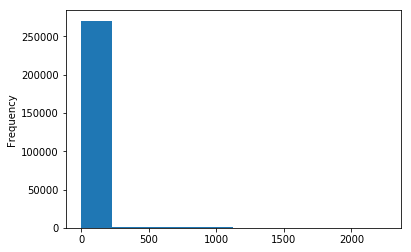

In [30]:
C4_truncated = X[X['C4'] != 0]['C4']
C4_truncated.plot.hist()

Still a lot of values really close to zero, let's see how C4 being above zero correlates with the dependent variable.

In [31]:
from scipy.stats import pearsonr
pearsonr(X.iloc[:train_shape[0],:]['C4']>0,y)

Seems to be pretty strong actually. One solution is to replace zero valued standard deviations with one to avoid the standardised deviation being blown up to infinity. I'm not sure if this is a good idea, but I'm also not sure what other solutions are plausible.

In [48]:
stds_temp = X.groupby('M5')['C4'].agg(['std'])
stds_temp = stds_temp.replace(0,1)
stds_temp

,std
M5,
F,1.000000
NaN,74.699614
T,1.000000


In [49]:
def feature_creation(categorical, numerical, method, df):
    
    #Creating some features by default because they will probably be needed anyway
    means_temp = df.groupby(categorical)[numerical].agg(['mean']).to_dict()
    means = df[categorical].map(means_temp['mean'])
    
    stds_temp = df.groupby(categorical)[numerical].agg(['std']).replace(0,1).to_dict()
    stds = df[categorical].map(stds_temp['std'])
    
    
    if method == 'counts':
        counts_temp = df[categorical].value_counts().to_dict()
        counts = df[categorical].map(counts_temp)
        return(counts)
    
    if method == 'means':
        return(means)
    
    if method == 'stds':
        return(stds)
    
    if method == "devs":
        devs = df[numerical] - means
        return(devs)
    
    if method == "std_devs":
        devs = df[numerical] - means
        std_devs = devs/stds
        return(std_devs)

That should fix it, let's double check though.

In [50]:
new_features = feature_aggregation_creation(combinations, X)
new_features.isna().sum().sum()

['M6', 'C1', 'std_devs']
['M4', 'V198', 'devs']
['ProductCD', 'V63', 'means']
['R_emaildomain', 'V108', 'means']
['R_emaildomain', 'V129', 'std_devs']
['R_emaildomain', 'V129', 'devs']
['R_emaildomain', 'V58', 'means']
['R_emaildomain', 'V276', 'stds']
['M4', 'V188', 'means']
['M4', 'V198', 'std_devs']
['M5', 'C4', 'std_devs']
['M6', 'V278', 'std_devs']


0

Wonderful! Let's finish the rest of the preprocessing.

In [51]:
#Adding them to our existing features
X = pd.concat([X,new_features], axis =1)

#Importing rankings of features based off of permutation importance

numerics_rankings = pd.read_csv('Data/numerics_rankings.csv')

#Gettingvariables to drop
weak_numerics = numerics_rankings[numerics_rankings['weight'] <=0]
weak_numerics_names = weak_numerics['feature'].tolist()

#Dropping them
X.drop(weak_numerics_names,axis=1,inplace=True)

In [52]:
#Converting strings to dummies, I couldn't do this before as I needed them as categorical values to create the aggregations
strings = X.select_dtypes(include = 'object')
numerics = X.select_dtypes(exclude= 'object')

del X

dummies = encoded = strings.apply(LabelEncoder().fit_transform)
del strings

X = pd.concat([numerics, dummies], axis =1)
del numerics

In [53]:
X_train = X.iloc[:train_shape[0],:]
X_test = X.iloc[train_shape[0]:,:]

train = pd.concat([y,X_train],axis=1)
train.to_csv('Data/train_preprocessed_1.csv',index=False)
X_test.to_csv('Data/test_preprocessed_1.csv', index=False)